# An introduction to GDAL for Earth Observation/Remote Sensing

This notebooks provides an introduction to GDAL both from a command line perspective and from python. To call GDAL within python we use the GDAL binding.

THe goal is to show how to use gdal to do basic earth image processing. In some cases, we also use rasterio and rioxarray in particular for plotting and to show how to use it along GDAL.

Useful links:

- GDAL API python reprojection and resampling: https://www.youtube.com/watch?v=1jHhQKJOQ5M
- GDAL API python tiling for processing: https://www.youtube.com/watch?v=H5uQ85VXttg


# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

In [2]:
from osgeo import gdal
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterio
import pandas as pd
import os   
import matplotlib.pyplot as plt
from shapely.geometry import box
import IPython.display as display
import folium
import contextily as ctx # import
from pathlib import Path

Check the system we are using:

- os system
- python version
- hostname

In [3]:
!uname -a
!lsb_release -a
!python --version
!hostname
!whoami

Linux bpasus 6.8.0-78-generic #78~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Aug 13 14:32:06 UTC 2 x86_64 x86_64 x86_64 GNU/Linux
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.5 LTS
Release:	22.04
Codename:	jammy
Python 3.10.4
bpasus
benoit


# Functions

In [4]:
def create_dir_and_check_existence(path: str) -> str:
  '''
  Create a new directory

  :param path: path to the directory
  :return: path to the directory
  '''

  try:
    os.makedirs(path)
  except:
    print ("directory already exists")
  return path

# Parameters and Arguments



In [5]:
in_dir = '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712'
out_dir = '/home/benoit/data/test_coding/'
in_filename_raster = 'prop_test.tif'

in_filename_raster_aoi = 'aoi_cropped.tif'

#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARG 4
out_suffix = "test_coding_20250901" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -9999 # currently not used: Nan value

In [6]:
#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier

directory already exists


In [7]:
print(out_dir)
print(os.getcwd())

/home/benoit/data/test_coding/outputs/output_test_coding_20250901
/home/benoit/data/test_coding/outputs/output_test_coding_20250901



# 1. Explore data

Let's open a tif using gdalopen. We explore the metadata:
- width and height
- resolution
- projection
- number of bands

1
1111
1111
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
(-95.6, 8.999999999999986e-05, 0.0, 29.90000948985959, 0.0, -8.999999999999986e-05)
(1111, 1111)
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
(1, 1111, 1111)


/home/benoit/data/test_coding/venv/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


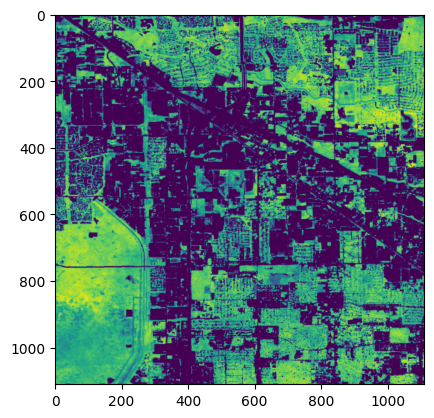

In [8]:
r_ds = gdal.Open(os.path.join(in_dir,in_filename_raster))
print(r_ds.RasterCount) #1 because only one band
print(r_ds.RasterXSize) #1111 columns
print(r_ds.RasterYSize) #1111 rows
print(r_ds.GetProjection()) #get projection info
print(r_ds.GetGeoTransform())
r_ds.GetRasterBand(1).DataType
del r_ds #close the file connection
#r_ds = None

r_ds = rasterio.open(os.path.join(in_dir,in_filename_raster))
print(r_ds.shape)
print(type(r_ds))

r_a = r_ds.read()
print(type(r_a))
print(r_a.shape)

plt.imshow(r_a.squeeze())
#plt.show()
#plt.close()

The image shows an urban area. We will extract the location to explore using folium.

In [9]:
r_ds = gdal.Open(os.path.join(in_dir,in_filename_raster))
print(r_ds.RasterCount) #1 because only one band
print(r_ds.RasterXSize) #1111 columns
print(r_ds.RasterYSize) #1111 rows
print(r_ds.GetProjection()) #get projection info
print(r_ds.GetGeoTransform())
print(r_ds.GetRasterBand(1).DataType)

1
1111
1111
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
(-95.6, 8.999999999999986e-05, 0.0, 29.90000948985959, 0.0, -8.999999999999986e-05)
7


In [10]:
!gdalinfo '{in_dir}/{in_filename_raster}' 

Driver: GTiff/GeoTIFF
Files: /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/prop_test.tif
       /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/prop_test.tif.aux.xml
Size is 1111, 1111
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            O

# 2. Reprojectiong and change of resoltution and cropping

## 2.1 Estimating UTM projection using raster bounds

In [11]:
r_ds = rasterio.open(os.path.join(in_dir,in_filename_raster))
print(type(r_ds))
raster_bounds = (r_ds.bounds)
print(raster_bounds)
print(type(raster_bounds))
#poly = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)
poly = box(*raster_bounds)
type(poly)
gdf = gpd.GeoDataFrame({'id':[1]}, geometry= [poly],crs=r_ds.crs.to_epsg())
gdf.to_file('raster_bounds.gpkg')
### Using GDALTINDEX
out_file_raster_bound_vector = 'raster_bounds.shp'
in_filename_raster = 'prop_test.tif'
in_raster_file = os.path.join(in_dir,'prop_test.tif')
list_args = ['gdaltindex',
              f'{out_file_raster_bound_vector}',
              f'{in_raster_file}'
              ]

cmd_str = ' '.join([str(elem) for elem in list_args])
import subprocess
env = os.environ.copy() #this is necessary in google colab
output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
print(cmd_str)

#let's reproject in the local UTM
#first get the bounds to get the EPSG code
utm_epsg_code = gdf.estimate_utm_crs()
print(utm_epsg_code)

<class 'rasterio.io.DatasetReader'>
BoundingBox(left=-95.6, bottom=29.80001948985959, right=-95.50000999999999, top=29.90000948985959)
<class 'rasterio.coords.BoundingBox'>
gdaltindex raster_bounds.shp /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/prop_test.tif
EPSG:32615


File /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/prop_test.tif is already in tileindex. Skipping it.


In [12]:
gdf.explore()

## 2.2 Reproject with GDAL warp


In the terminal:

```sh

gdalwarp -t_srs EPSG:32615 'prop_test.tif' 'prop_test_projected.tif'

```

In [13]:
out_file_raster = 'prop_test_projected.tif'
in_file_raster = os.path.join(in_dir,'prop_test.tif')
list_args = ['gdalwarp',
              f'-overwrite',
              f'-t_srs {utm_epsg_code}',
              f'{in_file_raster}',
              f'{out_file_raster}'
              ]
list_args

['gdalwarp',
 '-overwrite',
 '-t_srs EPSG:32615',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/prop_test.tif',
 'prop_test_projected.tif']

In [14]:
' '.join(list_args)

'gdalwarp -overwrite -t_srs EPSG:32615 /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/prop_test.tif prop_test_projected.tif'

In [15]:
[str(el) for el in list_args]

['gdalwarp',
 '-overwrite',
 '-t_srs EPSG:32615',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/prop_test.tif',
 'prop_test_projected.tif']

In [16]:
os.environ

environ{'BAMF_DESKTOP_FILE_HINT': '/var/lib/snapd/desktop/applications/code_code.desktop',
        'CHROME_DESKTOP': 'code.desktop',
        'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1000/bus',
        'DESKTOP_SESSION': 'ubuntu',
        'DISPLAY': ':0',
        'ELECTRON_NO_ATTACH_CONSOLE': '1',
        'FONTCONFIG_FILE': '/etc/fonts/fonts.conf',
        'FONTCONFIG_PATH': '/etc/fonts',
        'GDK_BACKEND': 'x11',
        'GDK_PIXBUF_MODULEDIR': '/snap/code/205/usr/lib/x86_64-linux-gnu/gdk-pixbuf-2.0/2.10.0/loaders',
        'GDK_PIXBUF_MODULE_FILE': '/home/benoit/snap/code/common/.cache/gdk-pixbuf-loaders.cache',
        'GDMSESSION': 'ubuntu',
        'GIO_LAUNCHED_DESKTOP_FILE': '/var/lib/snapd/desktop/applications/code_code.desktop',
        'GIO_LAUNCHED_DESKTOP_FILE_PID': '6772',
        'GIO_MODULE_DIR': '/home/benoit/snap/code/common/.cache/gio-modules',
        'GJS_DEBUG_OUTPUT': 'stderr',
        'GJS_DEBUG_TOPICS': 'JS ERROR;JS LOG',
        'GNOME_DESKTOP_SESSIO

gdalwarp -overwrite -t_srs EPSG:32615 /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/prop_test.tif prop_test_projected.tif


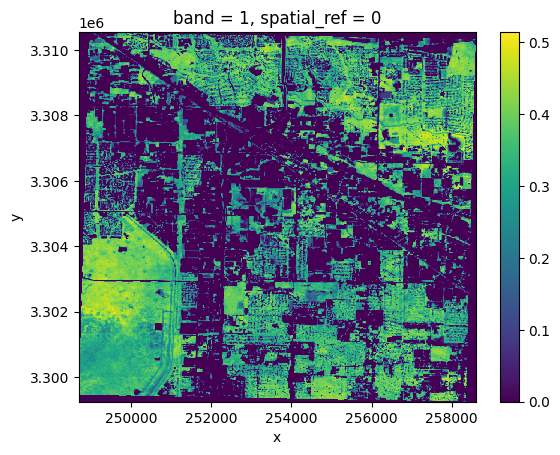

In [17]:
#Reproject only

out_file_raster = 'prop_test_projected.tif'
in_file_raster = os.path.join(in_dir,'prop_test.tif')
list_args = ['gdalwarp',
              f'-overwrite',
              f'-t_srs {utm_epsg_code}',
              f'{in_file_raster}',
              f'{out_file_raster}'
              ]

cmd_str = ' '.join([str(elem) for elem in list_args])
import subprocess
env = os.environ.copy() #this is necessary in google colab
output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
print(cmd_str)
r_rxr = rxr.open_rasterio(out_file_raster,
                          mask=True,
                          chunks='auto', #need to add dask here
                          cache = False
                          )
r_rxr.sel(band=1).plot()
plt.show()


The file was created and the projection was updated as visible below.

In [18]:
!ls -ltr
!echo -e "\n"
!gdalinfo prop_test_projected.tif

total 29600
-rw-rw-r-- 1 benoit benoit      145 Sep  1 09:29 raster_bounds.prj
-rw-rw-r-- 1 benoit benoit      108 Sep  1 09:29 raster_bounds.shx
-rw-rw-r-- 1 benoit benoit      236 Sep  1 09:29 raster_bounds.shp
-rw-rw-r-- 1 benoit benoit      321 Sep  1 09:29 raster_bounds.dbf
-rw-r--r-- 1 benoit benoit    98304 Sep  1 11:36 aoi_cropped.gpkg
-rw-rw-r-- 1 benoit benoit     2312 Sep  1 13:35 rgb.vrt
-rw-rw-r-- 1 benoit benoit  5403547 Sep  1 13:36 20160721_rgb.tif
-rw-rw-r-- 1 benoit benoit      145 Sep  1 14:16 tiles.prj
-rw-rw-r-- 1 benoit benoit     1252 Sep  1 14:16 tiles.shx
-rw-rw-r-- 1 benoit benoit    19684 Sep  1 14:16 tiles.shp
-rw-rw-r-- 1 benoit benoit    36786 Sep  1 14:16 tiles.dbf
-rw-rw-r-- 1 benoit benoit  2239476 Sep  1 20:54 prop_test_projected2.tif
-rw-rw-r-- 1 benoit benoit    61555 Sep  1 22:02 mosaic_tiles.vrt
drwxrwxr-x 2 benoit benoit    12288 Sep  1 22:23 tiles
-rw-rw-r-- 1 benoit benoit   598436 Sep  1 22:33 prop_test_projected3.tif
-rw-rw-r-- 1 benoit benoit

## 2.3 Reproject and change resolution

In [19]:

print(NA_value)
print(type(NA_value))
out_file_raster = 'prop_test_projected2.tif'
output_res = 20 #20 m
result = gdal.Warp(out_file_raster,
                   in_file_raster,
                   format='GTiff',
                   dstNodata=-9999,
                   dstSRS=utm_epsg_code,
                   resampleAlg='bilinear',
                   xRes=output_res,
                   yRes=output_res)
result=None

#Reproject and crop

-9999
<class 'int'>


Note that after the reprojection and change of resolution the image is 49

In [20]:
!ls -ltr
!echo -e "\n"
!gdalinfo prop_test_projected2.tif

total 29600
-rw-rw-r-- 1 benoit benoit      145 Sep  1 09:29 raster_bounds.prj
-rw-rw-r-- 1 benoit benoit      108 Sep  1 09:29 raster_bounds.shx
-rw-rw-r-- 1 benoit benoit      236 Sep  1 09:29 raster_bounds.shp
-rw-rw-r-- 1 benoit benoit      321 Sep  1 09:29 raster_bounds.dbf
-rw-r--r-- 1 benoit benoit    98304 Sep  1 11:36 aoi_cropped.gpkg
-rw-rw-r-- 1 benoit benoit     2312 Sep  1 13:35 rgb.vrt
-rw-rw-r-- 1 benoit benoit  5403547 Sep  1 13:36 20160721_rgb.tif
-rw-rw-r-- 1 benoit benoit      145 Sep  1 14:16 tiles.prj
-rw-rw-r-- 1 benoit benoit     1252 Sep  1 14:16 tiles.shx
-rw-rw-r-- 1 benoit benoit    19684 Sep  1 14:16 tiles.shp
-rw-rw-r-- 1 benoit benoit    36786 Sep  1 14:16 tiles.dbf
-rw-rw-r-- 1 benoit benoit    61555 Sep  1 22:02 mosaic_tiles.vrt
drwxrwxr-x 2 benoit benoit    12288 Sep  1 22:23 tiles
-rw-rw-r-- 1 benoit benoit   598436 Sep  1 22:33 prop_test_projected3.tif
-rw-rw-r-- 1 benoit benoit   652158 Sep  1 22:46 mosaic_cropped.tif
-rw-rw-r-- 1 benoit benoit    83



Driver: GTiff/GeoTIFF
Files: prop_test_projected2.tif
Size is 495, 565
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 15N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 15N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-93,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
  

In [21]:
r_ds = gdal.Open(os.path.join(out_dir,out_file_raster))
print(r_ds.RasterCount) #1 because only one band
print(r_ds.RasterXSize) #1111 columns, width
print(r_ds.RasterYSize) #1111 rows, height
print(r_ds.GetProjection()) #get projection info
print(r_ds.GetGeoTransform())
print(r_ds.GetRasterBand(1).DataType)

1
495
565
PROJCS["WGS 84 / UTM zone 15N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32615"]]
(248690.80018073446, 20.0, 0.0, 3310546.467970277, 0.0, -20.0)
7


## 2.4 Reproject and change resolution and crop

In [22]:
in_filename_raster_aoi = 'aoi_cropped.tif'

In [23]:
!ls -ltr '{out_dir}' 

total 29600
-rw-rw-r-- 1 benoit benoit      145 Sep  1 09:29 raster_bounds.prj
-rw-rw-r-- 1 benoit benoit      108 Sep  1 09:29 raster_bounds.shx
-rw-rw-r-- 1 benoit benoit      236 Sep  1 09:29 raster_bounds.shp
-rw-rw-r-- 1 benoit benoit      321 Sep  1 09:29 raster_bounds.dbf
-rw-r--r-- 1 benoit benoit    98304 Sep  1 11:36 aoi_cropped.gpkg
-rw-rw-r-- 1 benoit benoit     2312 Sep  1 13:35 rgb.vrt
-rw-rw-r-- 1 benoit benoit  5403547 Sep  1 13:36 20160721_rgb.tif
-rw-rw-r-- 1 benoit benoit      145 Sep  1 14:16 tiles.prj
-rw-rw-r-- 1 benoit benoit     1252 Sep  1 14:16 tiles.shx
-rw-rw-r-- 1 benoit benoit    19684 Sep  1 14:16 tiles.shp
-rw-rw-r-- 1 benoit benoit    36786 Sep  1 14:16 tiles.dbf
-rw-rw-r-- 1 benoit benoit    61555 Sep  1 22:02 mosaic_tiles.vrt
drwxrwxr-x 2 benoit benoit    12288 Sep  1 22:23 tiles
-rw-rw-r-- 1 benoit benoit   598436 Sep  1 22:33 prop_test_projected3.tif
-rw-rw-r-- 1 benoit benoit   652158 Sep  1 22:46 mosaic_cropped.tif
-rw-rw-r-- 1 benoit benoit    83

In [24]:
!gdaltindex aoi_cropped.gpkg '{in_dir}/aoi_cropped.tif' 

File /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/aoi_cropped.tif is already in tileindex. Skipping it.


In [25]:
!gdalinfo '{in_dir}/aoi_cropped.tif' 

Driver: GTiff/GeoTIFF
Files: /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/aoi_cropped.tif
       /home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/aoi_cropped.tif.aux.xml
Size is 320, 257
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
           

In [26]:
out_file_raster = 'prop_test_projected3.tif'
output_res = 10 #20 m
result = gdal.Warp(out_file_raster,
                   in_file_raster,
                   format='GTiff',
                   #dstNodata=-9999,
                   srcNodata=0,
                   dstNodata=0, #note we putting in a UINT16 if nodata is set to -9999 we may have a problem
                   dstSRS=utm_epsg_code,
                   cutlineDSName='aoi_cropped.gpkg',
                   cropToCutline=True,
                   xRes=output_res,
                   yRes=output_res)
result=None

#Reproject and crop

In [27]:
r_ds = gdal.Open(os.path.join(out_dir,out_file_raster))
print(r_ds.RasterCount) #1 because only one band
print(r_ds.RasterXSize) #1111 columns, width
print(r_ds.RasterYSize) #1111 rows, height
print(r_ds.GetProjection()) #get projection info
print(r_ds.GetGeoTransform())
print(r_ds.GetRasterBand(1).DataType)

1
284
263
PROJCS["WGS 84 / UTM zone 15N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32615"]]
(249853.67001215872, 10.0, 0.0, 3302561.0869599967, 0.0, -10.0)
7


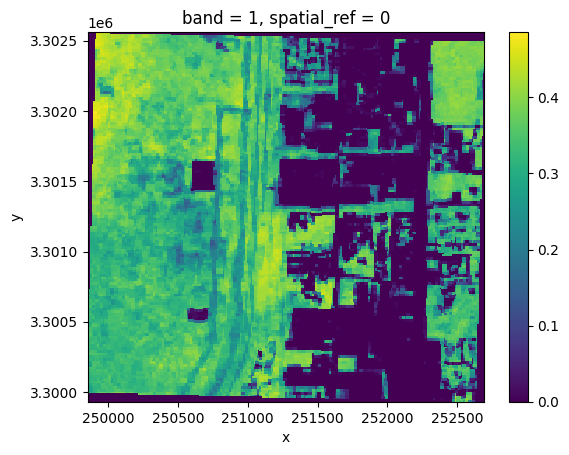

In [28]:
rxr.open_rasterio(out_file_raster).plot()

# 3. Visualization, color composite and virtual files 

## 3.1 Create color composite

In [29]:
sentinel2_metadata_df = pd.read_csv(os.path.join(in_dir,'Sentinel2_level2A_band_description_updated.csv'))
sentinel2_metadata_df

Band ID  Central wavelength  Bandwidth                   Description  \
0      B01               442.7       20.0               Coastal aerosol   
1      B02               492.7       65.0                          Blue   
2      B03               559.8       35.0                         Green   
3      B04               664.6       30.0                           Red   
4      B05               704.1       14.0                    Red edge 1   
5      B06               740.5       14.0                    Red edge 2   
6      B07               782.8       19.0                    Red edge 3   
7      B08               832.8      105.0         Near infrared (NIR) 1   
8      B8A               864.7       21.0                         NIR 2   
9      B09               945.1       19.0                  Water vapour   
10     B11              1613.7       90.0  Short-wave infrared (SWIR) 1   
11     B12              2202.4      174.0                        SWIR 2   
12     AOT                 NaN        NaN     Aerosol optical thickness   
13     WVP                 NaN        NaN    Scene average water vapour   
14     SCL                 NaN        NaN    Scene classification layer   

    Spatial resolution (m) Value range Data type  No data value  
0                       60   1 - 10000    uint16              0  
1                       10   1 - 10000    uint16              0  
2                       10   1 - 10000    uint16              0  
3                       10   1 - 10000    uint16              0  
4                       20   1 - 10000    uint16              0  
5                       20   1 - 10000    uint16              0  
6                       20   1 - 10000    uint16              0  
7                       10   1 - 10000    uint16              0  
8                       20   1 - 10000    uint16              0  
9                       60   1 - 10000    uint16              0  
10                      20   1 - 10000    uint16              0  
11                      20   1 - 10000    uint16              0  
12                      20   1 - 65535    uint16              0  
13                      20   1 - 65535    uint16              0  
14                      20     0 - 255     uint8              0

In [30]:
!ls -ltr '{in_dir}/sentinel-2-l2a'

total 420
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20181228
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160103
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160113
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160123
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160202
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160212
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160303
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160313
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160323
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160402
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160412
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160422
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160502
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160512
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160522
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160601
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160611
drwxrwxr-x 2 benoit benoit 4096 Jun 24  2024 20160621
drwxrwxr-x 2 benoi

In [31]:
date_val = '20160721'
!ls -ltr '{in_dir}/sentinel-2-l2a/{date_val}'

total 37456
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B02.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B03.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B04.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B05.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B06.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B07.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B08.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B09.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l2a_assets.B11.href_20160721.tif
-rw-rw-r-- 1 benoit benoit 2471246 Jul 12  2023 crop_proj_sentinel-2-l

In [32]:
in_path = os.path.join(in_dir,'sentinel-2-l2a',date_val)
file_pattern = f'crop_proj*.href_{date_val}.tif'
import glob
path_raster = os.path.join(in_path,file_pattern) #raw raster
print(path_raster)
files_raster_sat = glob.glob(path_raster,recursive=False)
print(len(files_raster_sat))
files_raster_sat.sort()
files_raster_sat

/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj*.href_20160721.tif
12


['/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B02.href_20160721.tif',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B03.href_20160721.tif',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B04.href_20160721.tif',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B05.href_20160721.tif',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B06.href_20160721.tif',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B07.href_20160721.tif',
 '/home/benoit/d

create a vrt then multiband file with gdal translate. We only need the top 3 files 
B02,B03,B04

In [33]:
files_raster = files_raster_sat[0:3]
files_raster.sort(reverse=True)
files_raster

['/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B04.href_20160721.tif',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B03.href_20160721.tif',
 '/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B02.href_20160721.tif']

In [34]:
out_file_vrt = 'rgb.vrt'
ds_RGB = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          callback=gdal.TermProgress_nocb)
ds_RGB= None
!ls -ltr


0...10...20...30...40...50...60...70...80...90...100 - done.
total 29600
-rw-rw-r-- 1 benoit benoit      145 Sep  1 09:29 raster_bounds.prj
-rw-rw-r-- 1 benoit benoit      108 Sep  1 09:29 raster_bounds.shx
-rw-rw-r-- 1 benoit benoit      236 Sep  1 09:29 raster_bounds.shp
-rw-rw-r-- 1 benoit benoit      321 Sep  1 09:29 raster_bounds.dbf
-rw-r--r-- 1 benoit benoit    98304 Sep  1 11:36 aoi_cropped.gpkg
-rw-rw-r-- 1 benoit benoit  5403547 Sep  1 13:36 20160721_rgb.tif
-rw-rw-r-- 1 benoit benoit      145 Sep  1 14:16 tiles.prj
-rw-rw-r-- 1 benoit benoit     1252 Sep  1 14:16 tiles.shx
-rw-rw-r-- 1 benoit benoit    19684 Sep  1 14:16 tiles.shp
-rw-rw-r-- 1 benoit benoit    36786 Sep  1 14:16 tiles.dbf
-rw-rw-r-- 1 benoit benoit    61555 Sep  1 22:02 mosaic_tiles.vrt
drwxrwxr-x 2 benoit benoit    12288 Sep  1 22:23 tiles
-rw-rw-r-- 1 benoit benoit   652158 Sep  1 22:46 mosaic_cropped.tif
-rw-rw-r-- 1 benoit benoit    83278 Sep  1 23:46 prop_test_01_01.tif
-rw-rw-r-- 1 benoit benoit    832

In [35]:
!cat rgb.vrt

<VRTDataset rasterXSize="1111" rasterYSize="1111">
  <SRS dataAxisToSRSAxisMapping="2,1">GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]</SRS>
  <GeoTransform> -9.5599999999999994e+01,  9.0000000000000006e-05,  0.0000000000000000e+00,  2.9900009489859588e+01,  0.0000000000000000e+00, -9.0000000000000006e-05</GeoTransform>
  <VRTRasterBand dataType="UInt16" band="1">
    <NoDataValue>0</NoDataValue>
    <ComplexSource>
      <SourceFilename relativeToVRT="0">/home/benoit/data/test_coding/data/output_data_stac_processing_sentinel2_20230712/sentinel-2-l2a/20160721/crop_proj_sentinel-2-l2a_assets.B04.href_20160721.tif</SourceFilename>
      <SourceBand>1</SourceBand>
      <SourceProperties RasterXSize="1111" RasterYSize="1111" DataType="U

Text(0.5, 1.0, 'Green bands')

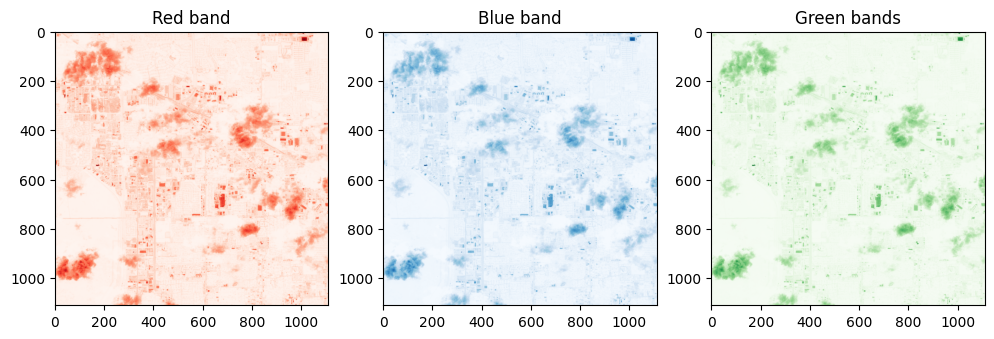

In [36]:
r_ds = rasterio.open('rgb.vrt')
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(12,4)) # Creates a 1x3 grid of subplots with plots of width 12 and height 4
axs[0].imshow(r_ds.read(1),cmap='Reds')
axs[0].set_title('Red band')
axs[1].imshow(r_ds.read(2),cmap='Blues')
axs[1].set_title('Blue band')
axs[2].imshow(r_ds.read(3),cmap='Greens')
axs[2].set_title('Green bands')

Let's use matplotlib, we can't see much because values are rescale between 0 and 1 to plot the RGB composite.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..17888].


Text(0.5, 1.0, 'RGB Composite')

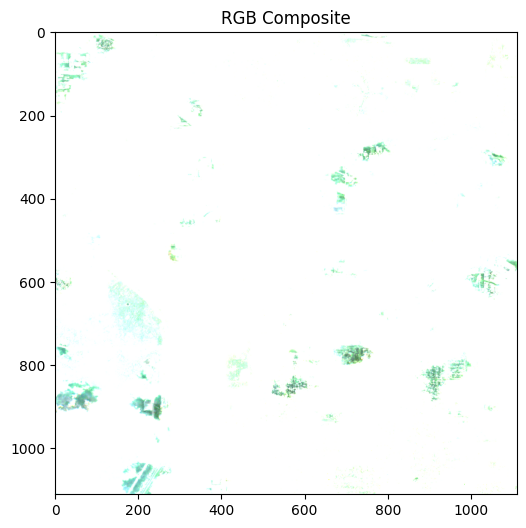

In [40]:
rgb = r_ds.read([1, 2, 3])
rgb = rgb.transpose(1, 2, 0)  # Change shape from (bands, rows, cols) to (rows, cols, bands)

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(rgb)
ax.set_title("RGB Composite")

Let's use rasterio that has a build in function to rescale values with minmax.

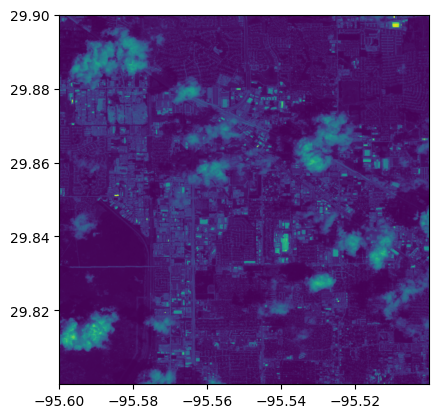

<Axes: >

In [41]:
from rasterio import plot
#note current data is in UINT16
plot.show(rasterio.open('rgb.vrt'),adjust = True) #use adjust to rescale between 0,255 or 0,1 

It doesn't recognize bands as Red, Blue, Green. We add this information using gdal_edit.py

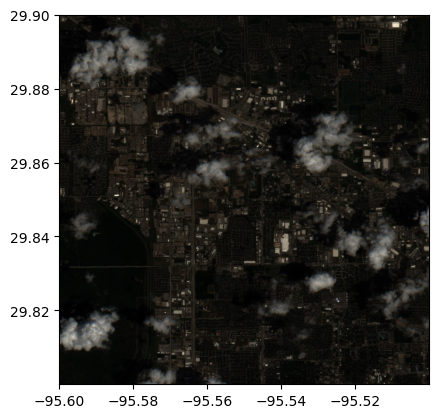

<Axes: >

In [42]:
!gdal_edit.py -colorinterp_1 red -colorinterp_2 green -colorinterp_3 blue rgb.vrt
from rasterio import plot
plot.show(rasterio.open('rgb.vrt'),adjust=True)

We can also create a tif image from the vrt file if necessary.

In [43]:
out_file_raster = f'{date_val}_rgb.tif'
gdal.Translate(out_file_raster,
               'rgb.vrt',
               format='GTiff',
               creationOptions=['COMPRESS:DEFLATE', 'TILED:YES'],
               callback=gdal.TermProgress_nocb)
#del ds_rgb   # close the VRT
!du -sh '{out_file_raster}'
!gdalinfo '{out_file_raster}'

0...10...20...30...40...50...60...70...80...90...100 - done.
5.2M	20160721_rgb.tif
Driver: GTiff/GeoTIFF
Files: 20160721_rgb.tif
Size is 1111, 1111
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,

We can see than plotting the tif or vrt shows the same image.

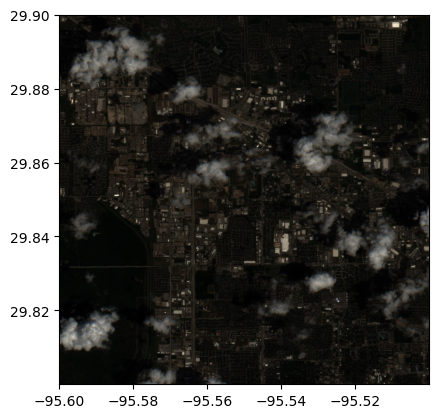

<Axes: >

In [44]:
plot.show(rasterio.open(out_file_raster),adjust=True) #it works be we can improve the scaling for visualization

## 3.2 Image stretching for color composite

We could still improve the image composite by rescaling with min-max or percentile

In [ ]:
'''
list_args = ['gdal_translate',
              f'-scale_1 {str(df_stats_RGB.loc[0,["min"]].values[0])} {str(df_stats_RGB.loc[0,["max"]].values[0])} {0} {255}',
              f'-scale_2 {str(df_stats_RGB.loc[1,["min"]].values[0])} {str(df_stats_RGB.loc[1,["max"]].values[0])} {0} {255}',
              f'-scale_3 {str(df_stats_RGB.loc[2,["min"]].values[0])} {str(df_stats_RGB.loc[2,["max"]].values[0])} {0} {255}',
              f'-ot Byte',
             'RGB_after.vrt',
             'RGB_after_stretched.tif']

cmd_str = ' '.join([str(elem) for elem in list_args])
import subprocess
env = os.environ.copy() #this is necessary in google colab
output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
print(cmd_str)
'''

## 3.3 Visualize using rioxarray

In [163]:
#band_selected = ['B04', 'B03', 'B02'] #red, green, blue
#ds.sel(time=slice('2018-06', '2019-01'))
#(ts_rxr.sel(band=band_selected,time=slice('2023-05-15','2023-07-15'))
#      .plot.imshow(col='time',robust=True,col_wrap=4) #if pass plot.imshow we need RGB
#)

r_rgb = rxr.open_rasterio('rgb.vrt')
r_rgb

<xarray.DataArray (band: 3, y: 1111, x: 1111)> Size: 7MB
[3702963 values with dtype=uint16]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 9kB -95.6 -95.6 -95.6 -95.6 ... -95.5 -95.5 -95.5
  * y            (y) float64 9kB 29.9 29.9 29.9 29.9 ... 29.8 29.8 29.8 29.8
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0

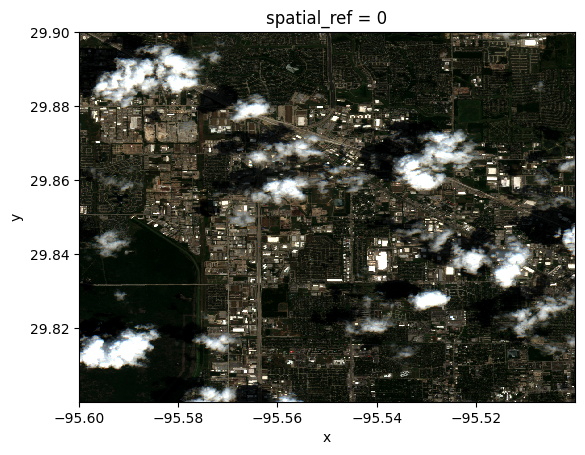

In [164]:
r_rgb.plot.imshow(robust=True)

```

ls '{in_dir}/*.tif' > filelist.txt
'{in_dir}/sentinel-2-l2a/{date_val}'
gdalbuildvrt -input_file_list filelist.txt merged.vrt
```

# 4. Raster calculation 

Use gdal_calc

# 5. Mosaic and tiling

## 5.1 Create tiles

Let's create tiles.

In [132]:
os.makedirs('tiles', exist_ok=True)

#!gdalretile '{in_dir}/
#in_file_raster = os.path.join(in_dir,'prop_test.tif')
!gdal_retile.py      \
  -ps 100 100        \
  -targetDir ./tiles \
  -of GTiff          \
  -co "compress=LZW" \
  '{in_dir}/prop_test.tif'

0...10...20...30...40...50...60...70...80...90...100 - done.


In [133]:
!ls -ltr tiles | wc
!ls -ltr tiles

    145    1298    9515
total 2124
-rw-rw-r-- 1 benoit benoit 15430 Sep  1 22:23 prop_test_01_01.tif
-rw-rw-r-- 1 benoit benoit 15689 Sep  1 22:23 prop_test_01_02.tif
-rw-rw-r-- 1 benoit benoit 17235 Sep  1 22:23 prop_test_01_03.tif
-rw-rw-r-- 1 benoit benoit 20188 Sep  1 22:23 prop_test_01_04.tif
-rw-rw-r-- 1 benoit benoit 20141 Sep  1 22:23 prop_test_01_05.tif
-rw-rw-r-- 1 benoit benoit 19480 Sep  1 22:23 prop_test_01_06.tif
-rw-rw-r-- 1 benoit benoit 19739 Sep  1 22:23 prop_test_01_07.tif
-rw-rw-r-- 1 benoit benoit 19474 Sep  1 22:23 prop_test_01_08.tif
-rw-rw-r-- 1 benoit benoit 17023 Sep  1 22:23 prop_test_01_09.tif
-rw-rw-r-- 1 benoit benoit 15725 Sep  1 22:23 prop_test_01_10.tif
-rw-rw-r-- 1 benoit benoit 16922 Sep  1 22:23 prop_test_01_11.tif
-rw-rw-r-- 1 benoit benoit  2360 Sep  1 22:23 prop_test_01_12.tif
-rw-rw-r-- 1 benoit benoit 14704 Sep  1 22:23 prop_test_02_01.tif
-rw-rw-r-- 1 benoit benoit 14938 Sep  1 22:23 prop_test_02_02.tif
-rw-rw-r-- 1 benoit benoit 15165 Sep  1 2

In [134]:
!gdalinfo ./tiles/prop_test_01_01.tif

Driver: GTiff/GeoTIFF
Files: ./tiles/prop_test_01_01.tif
Size is 100, 100
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]]

In [135]:
!gdaltindex tiles.shp ./tiles/*.tif 

File ./tiles/prop_test_01_01.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_02.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_03.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_04.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_05.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_06.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_07.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_08.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_09.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_10.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_11.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_01_12.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_02_01.tif is already in tileindex. Skipping it.
File ./tiles/prop_test_02_02.tif is already in tileindex. Skipping it.
File .

In [136]:
!ls -ltr

total 8408
-rw-rw-r-- 1 benoit benoit     145 Sep  1 09:29 raster_bounds.prj
-rw-rw-r-- 1 benoit benoit     108 Sep  1 09:29 raster_bounds.shx
-rw-rw-r-- 1 benoit benoit     236 Sep  1 09:29 raster_bounds.shp
-rw-rw-r-- 1 benoit benoit     321 Sep  1 09:29 raster_bounds.dbf
-rw-r--r-- 1 benoit benoit   98304 Sep  1 09:30 raster_bounds.gpkg
-rw-r--r-- 1 benoit benoit   98304 Sep  1 11:36 aoi_cropped.gpkg
-rw-rw-r-- 1 benoit benoit  598442 Sep  1 11:41 prop_test_projected3.tif
-rw-rw-r-- 1 benoit benoit    2312 Sep  1 13:35 rgb.vrt
-rw-rw-r-- 1 benoit benoit 5403547 Sep  1 13:36 20160721_rgb.tif
-rw-rw-r-- 1 benoit benoit     145 Sep  1 14:16 tiles.prj
-rw-rw-r-- 1 benoit benoit    1252 Sep  1 14:16 tiles.shx
-rw-rw-r-- 1 benoit benoit   19684 Sep  1 14:16 tiles.shp
-rw-rw-r-- 1 benoit benoit   36786 Sep  1 14:16 tiles.dbf
-rw-rw-r-- 1 benoit benoit 2239476 Sep  1 20:54 prop_test_projected2.tif
-rw-rw-r-- 1 benoit benoit   61555 Sep  1 22:02 mosaic_tiles.vrt
drwxrwxr-x 2 benoit benoit   

In [137]:
tiles_gdf = gpd.read_file('tiles.shp')
tiles_gdf

location  \
0    ./tiles/prop_test_01_01.tif   
1    ./tiles/prop_test_01_02.tif   
2    ./tiles/prop_test_01_03.tif   
3    ./tiles/prop_test_01_04.tif   
4    ./tiles/prop_test_01_05.tif   
..                           ...   
139  ./tiles/prop_test_12_08.tif   
140  ./tiles/prop_test_12_09.tif   
141  ./tiles/prop_test_12_10.tif   
142  ./tiles/prop_test_12_11.tif   
143  ./tiles/prop_test_12_12.tif   

                                              geometry  
0    POLYGON ((-95.6 29.90001, -95.591 29.90001, -9...  
1    POLYGON ((-95.591 29.90001, -95.582 29.90001, ...  
2    POLYGON ((-95.582 29.90001, -95.573 29.90001, ...  
3    POLYGON ((-95.573 29.90001, -95.564 29.90001, ...  
4    POLYGON ((-95.564 29.90001, -95.555 29.90001, ...  
..                                                 ...  
139  POLYGON ((-95.537 29.80101, -95.528 29.80101, ...  
140  POLYGON ((-95.528 29.80101, -95.519 29.80101, ...  
141  POLYGON ((-95.519 29.80101, -95.51 29.80101, -...  
142  POLYGON ((-95.51 29.80101, -95.501 29.80101, -...  
143  POLYGON ((-95.501 29.80101, -95.50001 29.80101...  

[144 rows x 2 columns]

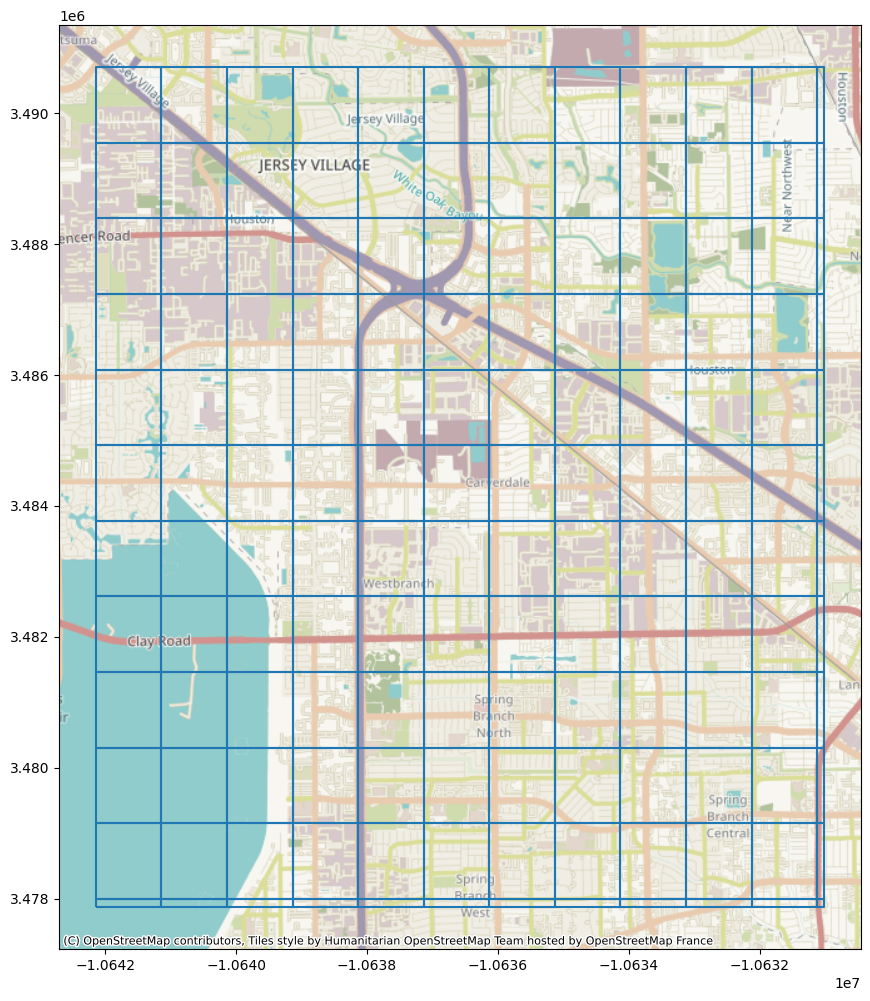

In [ ]:
interactive_map=False
if interactive_map is True:
    tiles_gdf.explore()
else:
    fig, ax = plt.subplots(figsize=(12, 12))
    (tiles_gdf.to_crs(epsg=3857)
            .boundary.plot(ax=ax)
    )
    ctx.add_basemap(ax)

In [ ]:
'''
# 2. Create a VRT mosaic
gdalbuildvrt mosaic.vrt ./tiles/*.tif

# 3. (Optional) Export mosaic to GeoTIFF
gdal_translate -of GTiff -co "COMPRESS=LZW" mosaic.vrt mosaic.tif
'''

## 5.2 Mosaicing tiles

In [ ]:
'''
if (dstNodata_val is None) and (srcNodata_val is None):
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          callback=gdal.TermProgress_nocb)
  else:
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          VRTNodata=dstNodata_val,
                          srcNodata=srcNodata_val,
                          callback=gdal.TermProgress_nocb)

  ds_ts.GetDescription()
'''

In [127]:
!gdalbuildvrt mosaic_tiles.vrt ./tiles/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Now crop with the aoi

Creating output file that is 1111P x 1111L.
Processing mosaic_tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image mosaic_tiles.vrt.
Copying nodata values from source mosaic_tiles.vrt to destination mosaic_cropped.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
total 10656
-rw-rw-r-- 1 benoit benoit     145 Sep  1 09:29 raster_bounds.prj
-rw-rw-r-- 1 benoit benoit     108 Sep  1 09:29 raster_bounds.shx
-rw-rw-r-- 1 benoit benoit     236 Sep  1 09:29 raster_bounds.shp
-rw-rw-r-- 1 benoit benoit     321 Sep  1 09:29 raster_bounds.dbf
-rw-r--r-- 1 benoit benoit   98304 Sep  1 09:30 raster_bounds.gpkg
-rw-r--r-- 1 benoit benoit   98304 Sep  1 11:36 aoi_cropped.gpkg
-rw-rw-r-- 1 benoit benoit    2312 Sep  1 13:35 rgb.vrt
-rw-rw-r-- 1 benoit benoit 5403547 Sep  1 13:36 20160721_rgb.tif
-rw-rw-r-- 1 benoit benoit     145 Sep  1 14:16 tiles.prj
-rw-rw-r-- 1 benoit benoit    1252 Sep  1 14:16 tiles.shx
-rw-rw-r-- 1 benoit benoit   19684 Sep  1 14:16 tiles.shp
-rw-

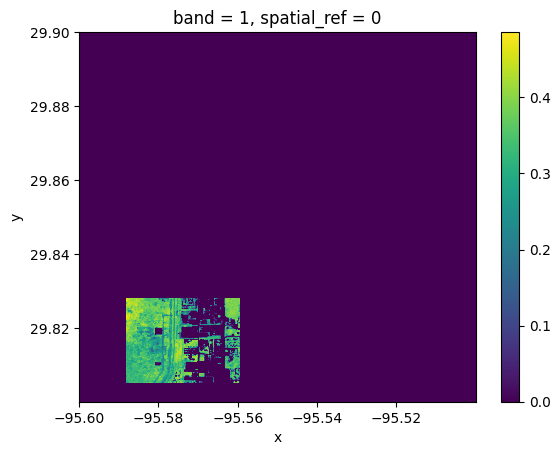

In [162]:
!gdalwarp -overwrite -cutline aoi_cropped.gpkg mosaic_tiles.vrt mosaic_cropped.tif 
!ls -ltr
rxr.open_rasterio('mosaic_cropped.tif').plot()

To crop so that the new extent is matched to the input AOI vector, we must use the option '-crop_to_cutline'

Creating output file that is 318P x 256L.
Processing mosaic_tiles.vrt [1/1] : 0Using internal nodata values (e.g. 0) for image mosaic_tiles.vrt.
Copying nodata values from source mosaic_tiles.vrt to destination mosaic_cropped.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


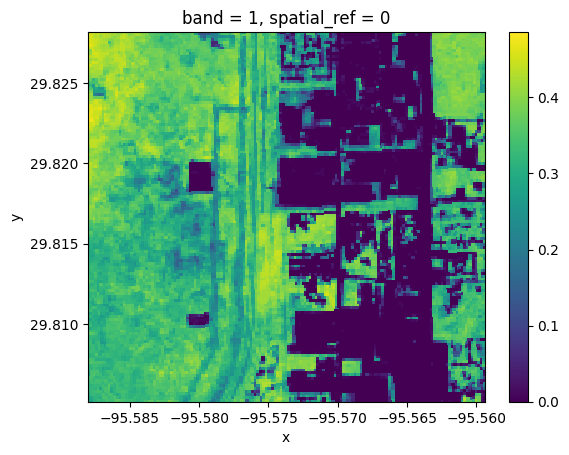

In [165]:
!gdalwarp -overwrite -cutline aoi_cropped.gpkg -crop_to_cutline mosaic_tiles.vrt mosaic_cropped.tif
rxr.open_rasterio('mosaic_cropped.tif').plot()

show a plot of shapefils aoi with tile grid

<Axes: >

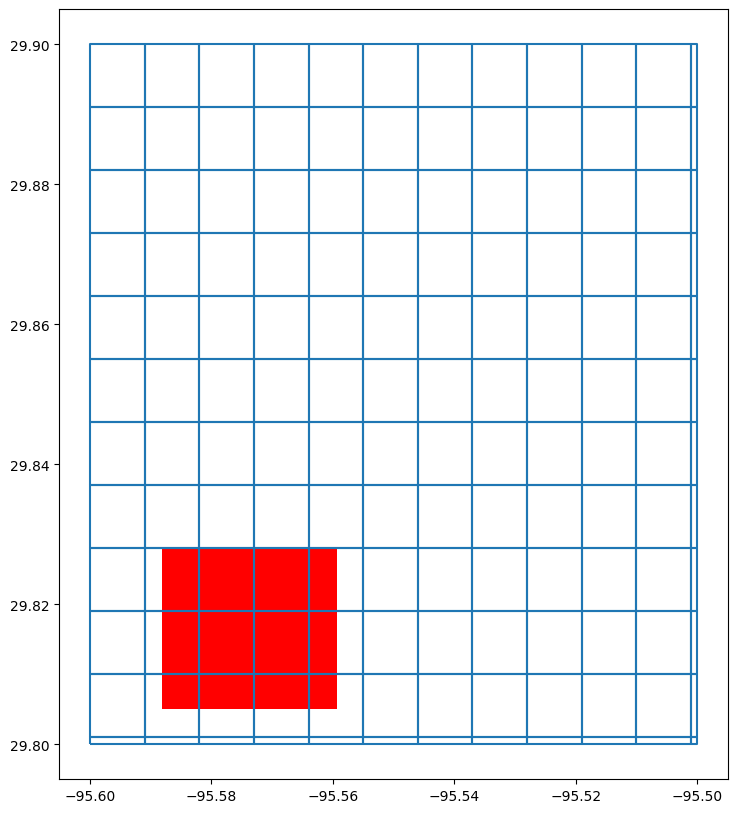

In [192]:
aoi_gdf = gpd.read_file('aoi_cropped.gpkg')
fig, ax = plt.subplots(figsize=(10, 10))
tiles_gdf.boundary.plot(ax=ax)
aoi_gdf.plot(ax=ax,color='red')


# 6. Parallel processing

Let's list all the first 10 files with red bands and reproject to UTM in a loop. We will show this with:

- shell loop
- function with joblib



Examples from chatgpt

## 6.1 Shell loop with gdal

In [230]:
print(utm_epsg_code)
print(out_dir)

EPSG:32615
/home/benoit/data/test_coding/outputs/output_test_coding_20250901


In [233]:
%%bash
mkdir -p /home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles_proj
for f in /home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/*.tif; do
    base=$(basename "$f")
    gdalwarp -t_srs EPSG:32615 "$f" "${out_dir}/tiles_proj/proj_${base}"
done

ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_01_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_02_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_03_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_04_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_05_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_06_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_07_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_08_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_09_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_10_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_01.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_02.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_03.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_04.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_05.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_06.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_07.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_08.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_09.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_10.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_11.tif' failed: No such file or directory


Creating output file that is 95P x 109L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_11_12.tif' failed: No such file or directory


Creating output file that is 12P x 100L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_01.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_02.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_03.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_04.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_05.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_06.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_07.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_08.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_09.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_10.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_11.tif' failed: No such file or directory


Creating output file that is 100P x 15L.


ERROR 4: Attempt to create new tiff file `/tiles_proj/proj_prop_test_12_12.tif' failed: No such file or directory


Creating output file that is 10P x 12L.


CalledProcessError: Command 'b'mkdir -p /home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles_proj\nfor f in /home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/*.tif; do\n    base=$(basename "$f")\n    gdalwarp -t_srs EPSG:32615 "$f" "${out_dir}/tiles_proj/proj_${base}"\ndone\n'' returned non-zero exit status 1.

In [ ]:
# Set input and output directories
IN_DIR="/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles"
OUT_DIR="/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles_proj"

# Create output directory
mkdir -p "$OUT_DIR"

# Export IN_DIR and OUT_DIR so GNU Parallel can access them
export IN_DIR OUT_DIR

# Use GNU Parallel
ls "$IN_DIR"/*.tif | parallel -j 4 ' 
    f={}
    base=$(basename "$f")
    gdalwarp -t_srs EPSG:32615 \
        -co "COMPRESS=LZW" -co "TILED=YES" \
        "$f" "$OUT_DIR/proj_${base}"

## 6.2 Parallel processing with joblib

In [202]:
list_files_tiles = glob.glob(f'{out_dir}/tiles/*.tif')
list_files_tiles.sort()
print(len(list_files_tiles))
list_files_tiles


144


['/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_01.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_02.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_03.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_04.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_05.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_06.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_07.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_08.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_09.tif',
 '/home/benoit/data/test_coding/outputs/output_test_coding_20250901/tiles/prop_test_01_10.tif',
 '/home/benoit/data/test_coding/outputs/

In [ ]:

def reproject_raster(in_file:str, out_file:str=None, target_srs=utm_epsg_code):
    if out_file is None:
        out_file = f'{(Path(in_file).stem)}_utm.tif'
    ds =gdal.Warp(out_file, in_file, dstSRS=target_srs)
    ds=None
    return out_file


for file in list_files_tiles[:3]:
    reproject_raster(in_file=file, 
                     out_file=None, 
                     target_srs=utm_epsg_code)


In [217]:
ls -ltr

total 19608
-rw-rw-r-- 1 benoit benoit     145 Sep  1 09:29 raster_bounds.prj
-rw-rw-r-- 1 benoit benoit     108 Sep  1 09:29 raster_bounds.shx
-rw-rw-r-- 1 benoit benoit     236 Sep  1 09:29 raster_bounds.shp
-rw-rw-r-- 1 benoit benoit     321 Sep  1 09:29 raster_bounds.dbf
-rw-r--r-- 1 benoit benoit   98304 Sep  1 09:30 raster_bounds.gpkg
-rw-r--r-- 1 benoit benoit   98304 Sep  1 11:36 aoi_cropped.gpkg
-rw-rw-r-- 1 benoit benoit    2312 Sep  1 13:35 rgb.vrt
-rw-rw-r-- 1 benoit benoit 5403547 Sep  1 13:36 20160721_rgb.tif
-rw-rw-r-- 1 benoit benoit     145 Sep  1 14:16 tiles.prj
-rw-rw-r-- 1 benoit benoit    1252 Sep  1 14:16 tiles.shx
-rw-rw-r-- 1 benoit benoit   19684 Sep  1 14:16 tiles.shp
-rw-rw-r-- 1 benoit benoit   36786 Sep  1 14:16 tiles.dbf
-rw-rw-r-- 1 benoit benoit 2239476 Sep  1 20:54 prop_test_projected2.tif
-rw-rw-r-- 1 benoit benoit   61555 Sep  1 22:02 mosaic_tiles.vrt
drwxrwxr-x 2 benoit benoit   12288 Sep  1 22:23 tiles/
-rw-rw-r-- 1 benoit benoit  598436 Sep  1 22:3

In [ ]:
from osgeo import gdal
from joblib import Parallel, delayed
import time


results = Parallel(n_jobs=2) (delayed(reproject_raster)(file) for file in list_files_tiles)


In [219]:
!ls -ltr

total 19608
-rw-rw-r-- 1 benoit benoit     145 Sep  1 09:29 raster_bounds.prj
-rw-rw-r-- 1 benoit benoit     108 Sep  1 09:29 raster_bounds.shx
-rw-rw-r-- 1 benoit benoit     236 Sep  1 09:29 raster_bounds.shp
-rw-rw-r-- 1 benoit benoit     321 Sep  1 09:29 raster_bounds.dbf
-rw-r--r-- 1 benoit benoit   98304 Sep  1 09:30 raster_bounds.gpkg
-rw-r--r-- 1 benoit benoit   98304 Sep  1 11:36 aoi_cropped.gpkg
-rw-rw-r-- 1 benoit benoit    2312 Sep  1 13:35 rgb.vrt
-rw-rw-r-- 1 benoit benoit 5403547 Sep  1 13:36 20160721_rgb.tif
-rw-rw-r-- 1 benoit benoit     145 Sep  1 14:16 tiles.prj
-rw-rw-r-- 1 benoit benoit    1252 Sep  1 14:16 tiles.shx
-rw-rw-r-- 1 benoit benoit   19684 Sep  1 14:16 tiles.shp
-rw-rw-r-- 1 benoit benoit   36786 Sep  1 14:16 tiles.dbf
-rw-rw-r-- 1 benoit benoit 2239476 Sep  1 20:54 prop_test_projected2.tif
-rw-rw-r-- 1 benoit benoit   61555 Sep  1 22:02 mosaic_tiles.vrt
drwxrwxr-x 2 benoit benoit   12288 Sep  1 22:23 tiles
-rw-rw-r-- 1 benoit benoit  598436 Sep  1 22:33

In [33]:
import os
import subprocess
from joblib import Parallel, delayed

# Function to run gdalwarp on one raster
def reproject_raster(input_file, output_dir, target_srs="EPSG:4326"):
    # Build output file name
    base_name = os.path.basename(input_file)
    output_file = os.path.join(output_dir, f"proj_{base_name}")
    
    # Build command
    cmd = [
        'gdalwarp',
        '-t_srs', target_srs,  # Target projection
        input_file,
        output_file
    ]
    
    # Run command
    try:
        subprocess.check_call(cmd)
        return f"Success: {output_file}"
    except subprocess.CalledProcessError as e:
        return f"Error processing {input_file}: {e}"

# Input & Output directories
input_dir = "/path/to/input"
output_dir = "/path/to/output"
os.makedirs(output_dir, exist_ok=True)

# List of raster files
raster_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".tif")]

# Parallel execution using all available cores
results = Parallel(n_jobs=-1)(delayed(reproject_raster)(f, output_dir) for f in raster_files)

# Print results
for res in results:
    print(res)


PermissionError: [Errno 13] Permission denied: '/path'